##To Vaccinate or Not to Vaccinate: It’s not a Question by #ZindiWeekendz
This article will provide a basic procedure on how to approach the [](https://zindi.africa/competitions/sea-turtle-rescue-forecast-challenge/data)[To Vaccinate or not vaccinate challenge](https://zindi.africa/competitions/to-vaccinate-or-not-to-vaccinate-its-not-a-question) hosted on Zindi; the fundamental steps involved will be described.

### Type of Problem

This challenge aims to develop a Machine Learning model to assess positive, negative, or neutral Twitter posts related to vaccinations. The solution will help the governments and other public health actors monitor public sentiment towards COVID-19 vaccinations and help improve public health policy, vaccine communication strategies, and vaccination programs worldwide.
In this challenge, we are working with text data; text data is initially non-numerical and must be processed before it can be fed into a Machine Learning algorithm.

For this we use Natural Language Processing - Natural language processing (NLP) is the ability of a computer program to understand human language as it is spoken and written -- referred to as natural language.

### Data Understanding

Here we check the data’s quality and completeness and explore variables and their relationship.

We are provided with 4 different kinds of files:

1. variable_definitions.csv - This file describes the different variables in the data.
2. sampleSubmission.csv - This file shows the structure of your submission file.
3. train.csv - This file contains relevant data/variables that will help train the final model; It can be split into train and test to test locally.
4. CaptureSite_category.csv - This file contains the capture sites and their category.

**Hint: Since this is a sentiment analysis challenge we’ll likely prioritize the textual variables.**

For this challenge it seems we are working with 4 different variables:

- **tweet_id:** Unique identifier of the tweet*
- **safe_tweet:** Text contained in the tweet. Some sensitive information has been removed like usernames and urls*
- **label:** Sentiment of the tweet (-1 for negative, 0 for neutral, 1 for positive)*
- **agreement:** The tweets were labeled by three people. Agreement indicates the percentage of the three reviewers that agreed on the given label. You may use this column in your training, but agreement data will not be shared for the test set.*

To get a clearer picture, it’s important to create a structural hypothesis with general knowledge to identify which variables are likely to affect the final output.

Data understanding is a step that gives a blueprint on what to work on in data preparation. It provides us with an idea of which variables we should focus on and transform(if need be) to work in our favor.

## **Set Up Your Work Environment**

Import necessary libraries and import the required datasets.

In [ ]:
# Check GPU type
!nvidia-smi

Thu Aug  4 08:29:01 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install and upgrade transformers and simpletransformers
!pip install transformers simpletransformers catboost -q -U

     |████████████████████████████████| 4.7 MB 4.3 MB/s 
     |████████████████████████████████| 249 kB 55.8 MB/s 
     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 101 kB 13.2 MB/s 
     |████████████████████████████████| 6.6 MB 43.9 MB/s 
     |████████████████████████████████| 596 kB 71.8 MB/s 
     |████████████████████████████████| 1.2 MB 23.5 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 9.1 MB 41.5 MB/s 
     |████████████████████████████████| 1.8 MB 40.0 MB/s 
     |████████████████████████████████| 365 kB 75.8 MB/s 
     |████████████████████████████████| 181 kB 60.5 MB/s 
     |████████████████████████████████| 156 kB 62.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 115 kB 72.7 MB/s 
     |████████████████████████████████| 212 kB 66.9 MB/s 
     |████████████████████████████████| 141 kB 26.8 MB/s 
     |█████████████

In [ ]:
# Import libraries
import pandas as pd
from tqdm import tqdm
import numpy as np
import gc
import re
import io

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn
from sklearn.metrics import log_loss, mean_squared_error, r2_score
from sklearn.metrics import *
from sklearn.model_selection import *

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

import random
import torch
from simpletransformers.classification import ClassificationModel
from scipy.special import softmax

from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Set seed for reproducability
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False
seed = 2022
seed_all(seed)

In [ ]:
# Load files to pandas dataframe
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')
sample_submission = pd.read_csv('SampleSubmission.csv')

# Preview train set
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0


In [ ]:
# Preview test set
test.head()

,tweet_id,safe_text
0,00BHHHP1,"<user> <user> ... &amp; 4 a vaccine given 2 healthy peeps, FDA think just not worth the AE risk unfortunately."
1,00UNMD0E,Students starting school without whooping cough vaccinations <url> #scpick
2,01AXPTJF,"I'm kinda over every ep of <user> being ""ripped from the headlines."" Measles? Let's get back to crime. #SVU"
3,01HOEQJW,How many innocent children die for lack of vaccination each year? Around 1.5 million. Too bad all their parents couldn't be here. #SB277
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though risk is low: Federal officials said Wednesday they're taking steps… <url>"


In [ ]:
# Preview sample submission
sample_submission.head()

,tweet_id,label
0,00BHHHP1,0
1,00UNMD0E,0
2,01AXPTJF,0
3,01HOEQJW,0
4,01JUKMAO,0


In [ ]:
# Target distribution
train.label.value_counts(normalize = True)

 0.000000    0.4908
 1.000000    0.4053
-1.000000    0.1038
 0.666667    0.0001
Name: label, dtype: float64

In [ ]:
train[~train.label.isin([-1, 0, 1])]

,tweet_id,safe_text,label,agreement
4798,RQMQ0L2A,#lawandorderSVU,NaN,NaN
4799,I cannot believe in this day and age some parents could be so oblivious to reality as to not #vaccinate their child.,1,0.666667,NaN


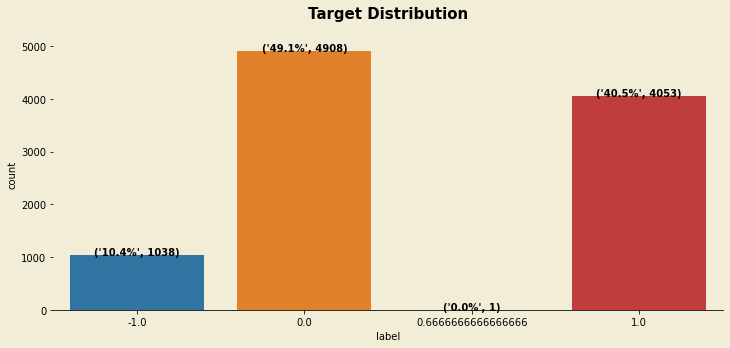

In [ ]:
#@title Target distribution { display-mode: "form" }
def without_hue(data,feature,ax):
    total=float(len(data))
    bars_plot=ax.patches

    for bars in bars_plot:
        percentage = '{:.1f}%'.format(100 * bars.get_height()/total)
        x = bars.get_x() + bars.get_width()/2.0
        y = bars.get_height()
        ax.text(x, y,(percentage,bars.get_height()),ha='center',fontweight='bold',fontsize=10)

fig = plt.figure(figsize=(12,5))
ax = plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_facecolor("#F2EDD7FF")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(linestyle="--",axis='x',color='gray')
ax.set_title('Target Distribution', ha='center',fontweight='bold',fontsize=15, y=1.05)

a=sns.countplot(data=train,x='label')
without_hue(train,'label',a)

- There are some labels with NaNs
- There is a text with a label of 0.667.  - This are clearly outliers and should be dropped
- There is a class imbalance of the target variables. This should be taken care of during cross validation

In [ ]:
# Drop NaNs and outliers in the training set
print(f'Shape of training set before dropping NaNs and removing outliers: {train.shape}')

train = train[train.label.isin([-1, 0, 1])].reset_index(drop = True)

print(f'Shape of training set after dropping NaNs and removing outliers: {train.shape}')

Shape of training set before dropping NaNs and removing outliers: (10001, 4)
Shape of training set after dropping NaNs and removing outliers: (9999, 4)


## Text cleaning

In [ ]:
#@title Cleaning text
def clean_text(text):
  # Remove <user> tags
  test = str(text)
  text = re.sub(r'<.*?>', '', text)
  # Replace &amp; with 'and'
  text = re.sub(r"&amp;", "and", text)
  # Replace punctuation characters with spaces
  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
  translate_dict = dict((c, " ") for c in filters)
  translate_map = str.maketrans(translate_dict)
  text = text.translate(translate_map)
  # Convert text to lowercase
  text = text.strip().lower()
  return text

train.safe_text = train.safe_text.astype(str)
test.safe_text = test.safe_text.astype(str)

train['cleaned_text'] = train.safe_text.apply(lambda x: clean_text(x))
test['cleaned_text'] = test.safe_text.apply(lambda x: clean_text(x))
train.head()

,tweet_id,safe_text,label,agreement,cleaned_text
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0,me and the big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0,i'm 100 thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0,whatcausesautism vaccines do not vaccinate your child
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0,i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it but i don't trust that
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0,thanks to catch me performing at la nuit nyc 1134 1st ave show starts at 6 jennifair mmr…


## Calculate length of each text

In [ ]:
# Calculate length of each text
train['length'] = train.safe_text.apply(lambda x: len(x.split(' ')))
test['length'] = train.safe_text.apply(lambda x: len(x.split(' ')))
train.head()

,tweet_id,safe_text,label,agreement,cleaned_text,length
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0,me and the big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,15
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0,i'm 100 thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day,25
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0,whatcausesautism vaccines do not vaccinate your child,7
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0,i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it but i don't trust that,28
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0,thanks to catch me performing at la nuit nyc 1134 1st ave show starts at 6 jennifair mmr…,20


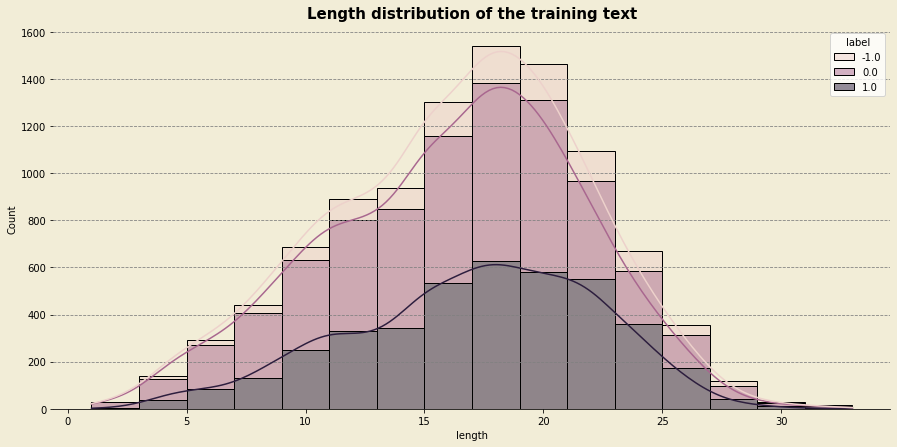

In [ ]:
#@title Length distribution of the training text
fig = plt.figure(figsize=(15,7))
ax = plt.axes()
ax.set_facecolor("#F2EDD7FF")
fig.patch.set_facecolor("#F2EDD7FF")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(linestyle="--",axis='y',color='gray')
ax.set_title('Length distribution of the training text', fontweight='bold',fontsize=15, y=1.01)

a=sns.histplot(data=train,x='length',hue='label',kde=True,binwidth=2,multiple='stack')

- Majority of the text is centered around 16 words
- There is some text with just one word
- Maximum number of words for a text in training set is 33

In [ ]:
# Function to remove stop words
def remove_stopwords(text):
    text = str(text).lower()
    text = text.split(" ")
    lemma = WordNetLemmatizer()
    text = [lemma.lemmatize(i) for i in text if i not in set(stopwords.words('english'))]
    text = " ".join(text)
    return(text)

train['no_stopwords'] = train.cleaned_text.apply(remove_stopwords)
test['no_stopwords'] = test.cleaned_text.apply(remove_stopwords)
train.head()

,tweet_id,safe_text,label,agreement,cleaned_text,length,no_stopwords
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #MB #MBS #MMR #STEGMANLIFE @ Stegman St. <url>,0.0,1.0,me and the big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,15,big homie meanboy3000 meanboy mb mb mmr stegmanlife stegman st
1,E3303EME,I'm 100% thinking of devoting my career to proving autism isn't caused by vaccines due to the IDIOTIC posts I've seen about World Autism Day,1.0,1.0,i'm 100 thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day,25,i'm 100 thinking devoting career proving autism caused vaccine due idiotic post i've seen world autism day
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE YOUR CHILD",-1.0,1.0,whatcausesautism vaccines do not vaccinate your child,7,whatcausesautism vaccine vaccinate child
3,1DR6ROZ4,"I mean if they immunize my kid with something that won't secretly kill him years down the line then I'm all for it, but I don't trust that",-1.0,1.0,i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it but i don't trust that,28,mean immunize kid something secretly kill year line i'm trust
4,J77ENIIE,Thanks to <user> Catch me performing at La Nuit NYC 1134 1st ave. Show starts at 6! #jennifair #mmr… <url>,0.0,1.0,thanks to catch me performing at la nuit nyc 1134 1st ave show starts at 6 jennifair mmr…,20,thanks catch performing la nuit nyc 1134 1st ave show start 6 jennifair mmr…


In [ ]:
# Prepare data for frequent moments
train_0 = train[train.label == 0].reset_index(drop = 1)
train_1 = train[train.label == 1].reset_index(drop = 1)
train_m1 = train[train.label == -1].reset_index(drop = 1)

# Get most frequent words
def get_count(dataframe):
    dic = {}
    for i in dataframe['no_stopwords']:
        for j in i.split(" "):
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1
    dic = sorted(dic.items() , key = lambda x:x[1],reverse=True)
    return(dic)

train_0_freq = get_count(train_0)
train_1_freq = get_count(train_1)
train_m1_freq = get_count(train_m1)

train_0_top, train_0_topcount = [], []
train_1_top, train_1_topcount = [], []
train_m1_top, train_m1_topcount = [], []

count = 0
for i in train_0_freq:
    if(count<50):
        train_0_top.append(i[0])
        train_0_topcount.append(i[1])
    else:
        break

for i in train_1_freq:
    if(count<50):
        train_1_top.append(i[0])
        train_1_topcount.append(i[1])
    else:
        break

for i in train_m1_freq:
    if(count<50):
        train_m1_top.append(i[0])
        train_m1_topcount.append(i[1])
    else:
        break

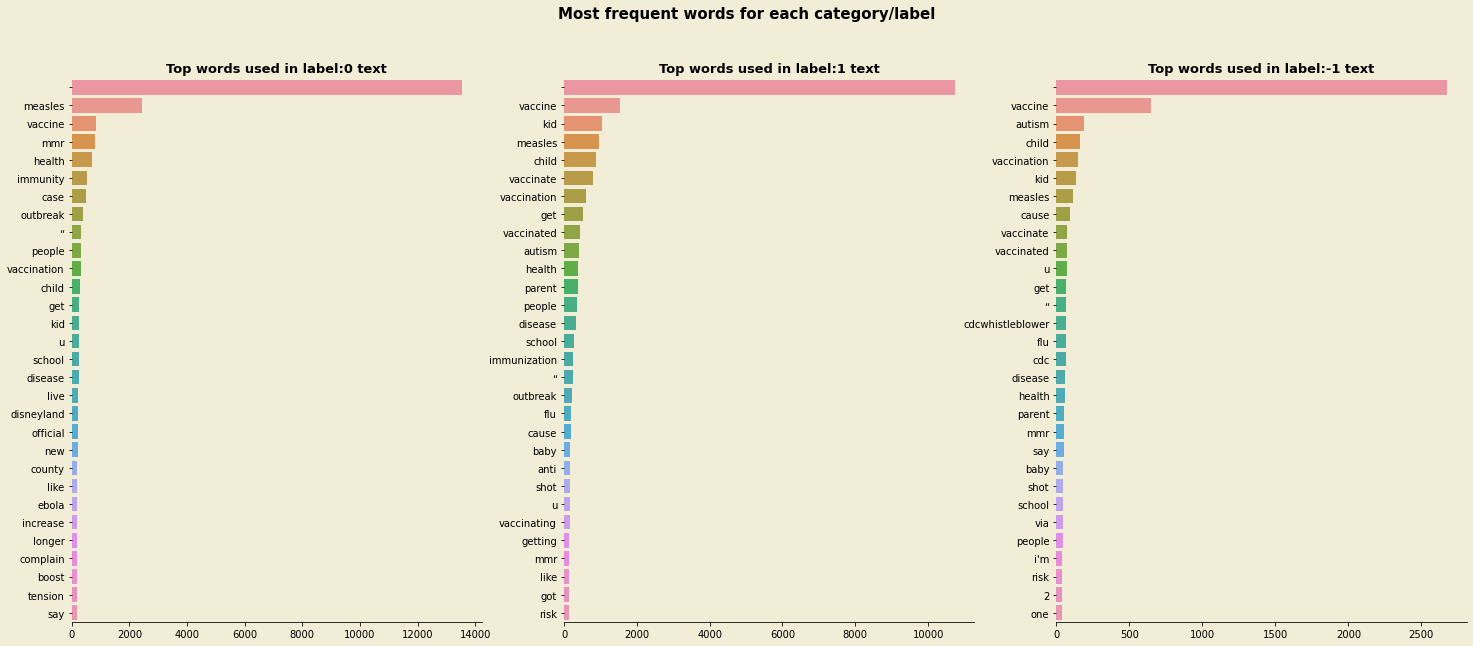

In [ ]:
#@title Most frequent words per label
# Most frequent words
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(25,10))
fig.patch.set_facecolor('#F2EDD7FF')

for i in range(0,3):
    ax[i].set_facecolor('#F2EDD7FF')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
    ax[i].grid(linestyle="--",axis='y',color='gray')


fig.suptitle('Most frequent words for each category/label', fontweight='bold',fontsize=15)
sns.barplot(y=train_0_top[0:30],x=train_0_topcount[0:30],ax=ax[0])
sns.barplot(y=train_1_top[0:30],x=train_1_topcount[0:30],ax=ax[1])
sns.barplot(y=train_m1_top[0:30],x=train_m1_topcount[0:30],ax=ax[2])
ax[0].set_title("Top words used in label:0 text", fontsize=13, fontweight='bold')
ax[1].set_title("Top words used in label:1 text", fontsize=13, fontweight='bold')
ax[2].set_title("Top words used in label:-1 text", fontsize=13, fontweight='bold')
plt.show()

In [ ]:
train_0_para = " ".join([word for word in train_0['cleaned_text']])
train_1_para = " ".join([word for word in train_1['cleaned_text']])
train_m1_para = " ".join([word for word in train_m1['cleaned_text']])
train_m1_para

"whatcausesautism vaccines  do not vaccinate your child i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it  but i don't trust that cdc lied and hid data that black boys have an 340  uncreased risk of developing autism after mmr  cdcwhistleblower help vaccines causing autism other than that  his defense is not against vaccines being harmful   but the american life being unhealthy i'm not vaccinating my kids lol yeah  i'll just stick to my regular vaccines  oh wait  that gives me autism cia  no more vaccination campaigns in spy ops  via  harm from protected medic status ruse will linger vaccine brain damage cover up implodes    on  discussing  cdcwhistleblower centers for disease control  this year’s flu vaccine doesn’t work   health  flu  cure  failure  sick  cdc  really ty  fought hard 2 not vaccinate my kids  yrs of ppl's judgements  don't get hurt  get smart conservative neurosurgeon ben carson says vaccines are a public

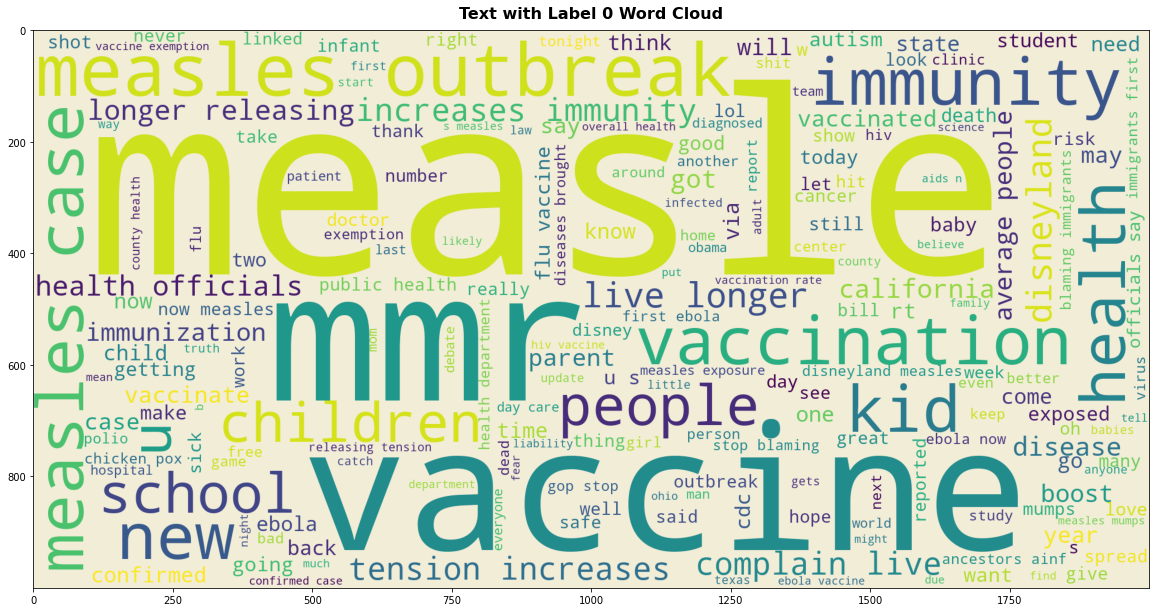

In [ ]:
#@title Word Cloud for Text With Label 0
wordcloud=WordCloud(width=2000,height=1000,background_color='#F2EDD7FF').generate(train_0_para)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.title("Text with Label 0 Word Cloud", fontsize=16, fontweight='bold', y = 1.01)
plt.show()

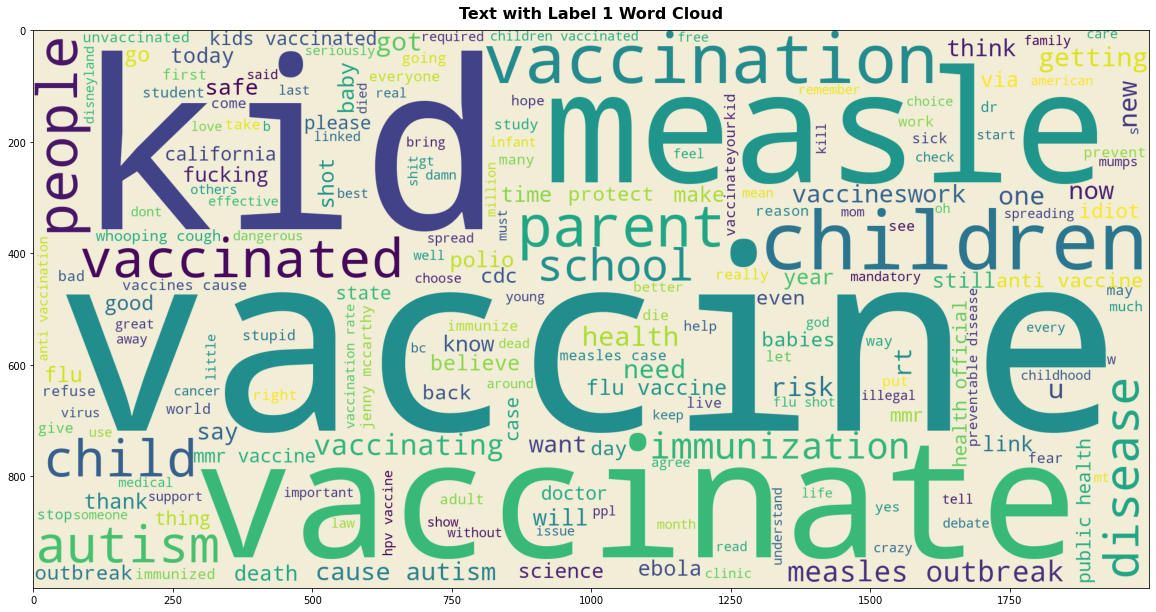

In [ ]:
#@title Word Cloud for Text With Label 1
wordcloud=WordCloud(width=2000,height=1000,background_color='#F2EDD7FF').generate(train_1_para)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.title("Text with Label 1 Word Cloud", fontsize=16, fontweight='bold', y = 1.01)
plt.show()

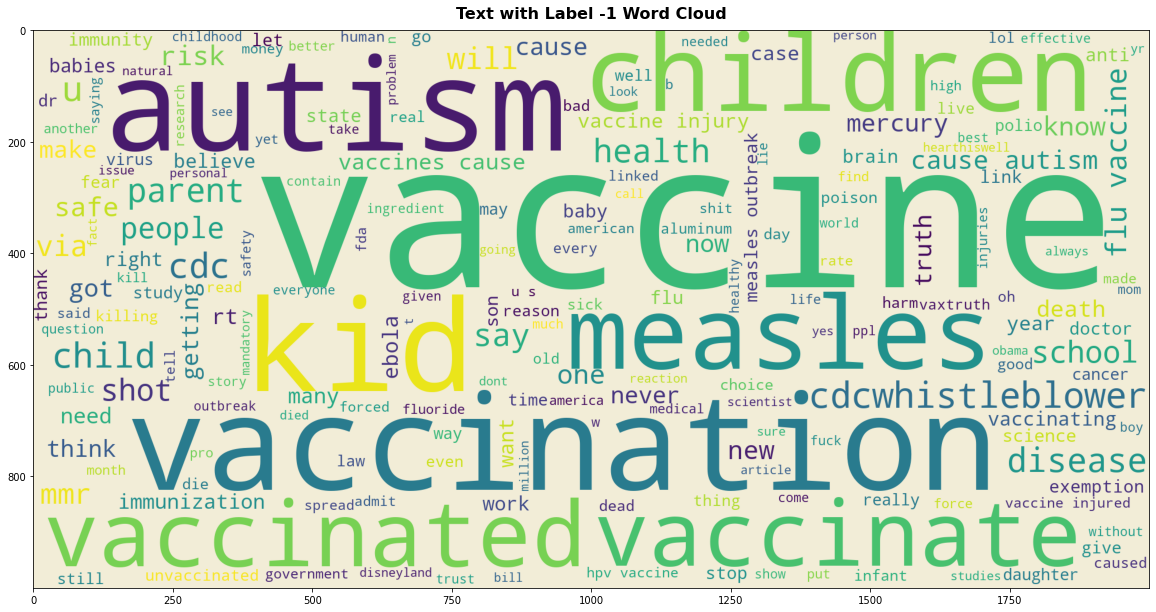

In [ ]:
#@title Word Cloud for Text With Label -1
wordcloud=WordCloud(width=2000,height=1000,background_color='#F2EDD7FF').generate(train_m1_para)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud)
plt.title("Text with Label -1 Word Cloud", fontsize=16, fontweight='bold', y = 1.01)
plt.show()

### Model Training

For text data, the first step is to transform a piece of text into a canonical form. Lemmatization is an example of normalization. A lemma is the dictionary form of a word - It is the process of reducing multiple inflections to that single dictionary form.

After the normalized text, we can take up the next step of encoding it into numerical form. The goal is to identify the particular features of the text that will be relevant to us for the specific task we want to perform - and then get these features extracted in numerical form that is accessible by the ML algorithm. This can be done by turning a piece of text into a vector.

Common approaches include:

- Term Frequency-Inverse Document Frequency(TD-IDF)
- Vectorization
- Word Embedding

The approach of TD-IDF is to give less importance to words that contain less information and are common in documents, such as ‘the’ and ‘this’ - and to give higher priority to words that have relevant information and appears less frequently. Thus TD-IDF assigns weights to terms to signify their relevance in the documents.

The first step is to split the train data into training and validation sets. Data splitting is done to avoid overfitting - meaning the data fits too well to the train data and fails reliably to fit additional data.

In [ ]:
# Split data into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(train, train.label, stratify=train.label, random_state=seed, test_size=0.2, shuffle=True)

# Ensure the split maintains the target distribution
display(y_train.value_counts(normalize = True), y_valid.value_counts(normalize = True))

 0.0    0.490811
 1.0    0.405301
-1.0    0.103888
Name: label, dtype: float64

 0.0    0.4910
 1.0    0.4055
-1.0    0.1035
Name: label, dtype: float64

For this challenge, we will use the Logistic Regression and TfidfVectorizer algorithm.  Logistic regression is a statistical analysis method to predict a binary outcome, such as yes or no, based on prior observations of a data set.A logistic regression model predicts a dependent data variable by analyzing the relationship between one or more existing independent variables.

In [ ]:
# Always start with these features. They work (almost) everytime!
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

# Fitting TF-IDF to both training and test sets
X_train_ctv =  tfv.fit_transform(X_train.cleaned_text)
X_valid_ctv = tfv.transform(X_valid.cleaned_text)
X_test_ctv = tfv.transform(test.cleaned_text)

In [ ]:
# Stratified cros validation with 10 folds
n_folds = 10
folds = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
total_score = 0
test_predictions_probas = []

for i, (train_indices,val_indices) in enumerate(folds.split(X_train_ctv, y_train)):
    # Building the subsets
    sub_X_train,sub_y_train = X_train_ctv[train_indices], np.take(y_train, train_indices, axis=0)
    sub_X_val,sub_y_val = X_train_ctv[val_indices], np.take(y_train, val_indices, axis=0)

    # Training the model
    model = LogisticRegression(C=1, penalty='l2')
    model.fit(sub_X_train, sub_y_train)

    # Calculation RMSE score on validation set
    val_predictions_proba = model.predict_proba(sub_X_val)
    # Shifting the probability
    val_prediction = [(pred.argmax()-1)*pred[pred.argmax()]
                      for pred in val_predictions_proba]
    score = np.sqrt(mean_squared_error(sub_y_val, val_prediction))
    print("Fold {}: {}".format(i, score))
    total_score += score

    # Predicting probabilities using the current model
    test_prediction = model.predict_proba(X_test_ctv)
    test_predictions_probas.append(test_prediction)

print("Machine Learning Average score: {}".format(total_score/n_folds))

Fold 0: 0.6031285628815061
Fold 1: 0.5864125015913705
Fold 2: 0.5921356358495637
Fold 3: 0.5829872316605036
Fold 4: 0.5841588583026788
Fold 5: 0.5777267331373962
Fold 6: 0.5919503594870934
Fold 7: 0.6095654483451917
Fold 8: 0.5989411895126658
Fold 9: 0.5933657005208863
Machine Learning Average score: 0.5920372221288857


In [ ]:
# Prepare the data for deep learning
train_df = train[['cleaned_text', 'label']]
train_df.rename(columns = {'cleaned_text': 'text', 'label': 'labels'}, inplace = True)
test_df = test[['cleaned_text']]
test_df['target'] = 0
test_df.columns = ['text', 'labels']

display(train_df.head(), test_df.head())

,text,labels
0,me and the big homie meanboy3000 meanboy mb mbs mmr stegmanlife stegman st,0.0
1,i'm 100 thinking of devoting my career to proving autism isn't caused by vaccines due to the idiotic posts i've seen about world autism day,1.0
2,whatcausesautism vaccines do not vaccinate your child,-1.0
3,i mean if they immunize my kid with something that won't secretly kill him years down the line then i'm all for it but i don't trust that,-1.0
4,thanks to catch me performing at la nuit nyc 1134 1st ave show starts at 6 jennifair mmr…,0.0


,text,labels
0,and 4 a vaccine given 2 healthy peeps fda think just not worth the ae risk unfortunately,0
1,students starting school without whooping cough vaccinations scpick,0
2,i'm kinda over every ep of being ripped from the headlines measles let's get back to crime svu,0
3,how many innocent children die for lack of vaccination each year around 1 5 million too bad all their parents couldn't be here sb277,0
4,cdc eyeing bird flu vaccine for humans though risk is low federal officials said wednesday they're taking steps…,0


In [ ]:
train_df.dtypes

text       object
labels    float64
dtype: object

In [ ]:
# Function to train model
def get_model(model_type, model_name, n_epochs = 2, train_batch_size = 112, eval_batch_size = 144, seq_len = 134, lr = 1.8e-5):
  model = ClassificationModel(model_type, model_name,num_labels=1, args={'train_batch_size':train_batch_size,"eval_batch_size": eval_batch_size,
                                                                         'reprocess_input_data': True,
                                                                    'overwrite_output_dir': True, 'fp16': False,
                                                                    'do_lower_case': False, 'num_train_epochs': n_epochs,
                                                                    'max_seq_length': seq_len,'regression': True,
                                                                    'manual_seed': 2, "learning_rate":lr,
                                                                    "save_eval_checkpoints": False,
                                                                    "save_model_every_epoch": False,})
  return model

In [ ]:
# Train model
total_score = 0
test_predictions_probas = []

for i, (train_indices,val_indices) in enumerate(folds.split(train_df, train_df.labels)):
    X_train, X_test = train_df.loc[train_indices], train_df.loc[val_indices]

    model = get_model('roberta', 'roberta-large', n_epochs=3, train_batch_size=16, eval_batch_size=16, lr = 5e-6)

    model.train_model(X_train)

    preds_val = model.eval_model(X_test)[1]
    preds_val = np.clip(preds_val, -1, 1)

    mse_score = mean_squared_error(X_test['labels'], preds_val)**0.5
    total_score += score

    print(f"Fold {i}: {mse_score}")

    test_preds = model.eval_model(test_df)[1]
    test_preds = np.clip(test_preds, -1, 1)

    test_predictions_probas.append(test_preds)

print("Deep Learning Average score: {}".format(total_score/n_folds))

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 0: 0.45835905105433344


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 1: 0.48275539359291875


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 2: 0.5013199393838997


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 3: 0.5009034019595546


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 4: 0.4929640945343143


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 5: 0.46105291052103714


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 6: 0.4916168368337959


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 7: 0.485607709335053


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/8999 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 8: 0.484676017240767


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.weight', 'classif

  0%|          | 0/9000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/563 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/63 [00:00<?, ?it/s]

Fold 9: 0.48602767757052046


  0%|          | 0/5177 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/324 [00:00<?, ?it/s]

Deep Learning Average score: 0.5933657005208862


## Submission

In [ ]:
# Create a submission file and upload to zindi for scoring
test_prediction_proba = np.mean(test_predictions_probas, axis=0)
submission = pd.DataFrame({"tweet_id":test.tweet_id, "label":test_prediction_proba})
submission.to_csv("submission.csv", index=False)